In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task, OutputModel

from amplify.data import DataGenerator, DataSplit

## Load Data

In [2]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.shape

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!


## Data Processing

In [ ]:
# ClearML Stuff
#task = Task.init(project_name="amplify", task_name="encoder-decoder-lstm", output_uri="s3://amplify-microgrid-ai")

In [ ]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [ ]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds, norm_layer = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

2022-02-02 06:12:12.218258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:12:12.239700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:12:12.240795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:12:12.243040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y), (norm_layer)!


In [ ]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


### Reviewing Data

In [ ]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


x_train shape:  (1547, 48, 5)
y_train shape:  (1547, 48, 2)


## Modeling

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Normalization, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [ ]:
norm_inputs = Input(shape=(SERIES, x_train.shape[-1]))
nn_inputs = norm_layer(norm_inputs)
nn_layer = Dense(200)
encoder_inputs = nn_layer(nn_inputs)
encoder_l1 = LSTM(200, return_state=True, dropout=.25)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(SERIES)(encoder_outputs1[0])

decoder_l1 = LSTM(200, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(y_train.shape[-1], activation='relu'))(decoder_l1)

model = Model(norm_inputs, decoder_outputs1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 5)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 48, 5)        11          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 48, 200)      1200        ['normalization[0][0]']          
                                                                                                  
 lstm (LSTM)                    [(None, 200),        320800      ['dense[0][0]']                  
                                 (None, 200),                                                 

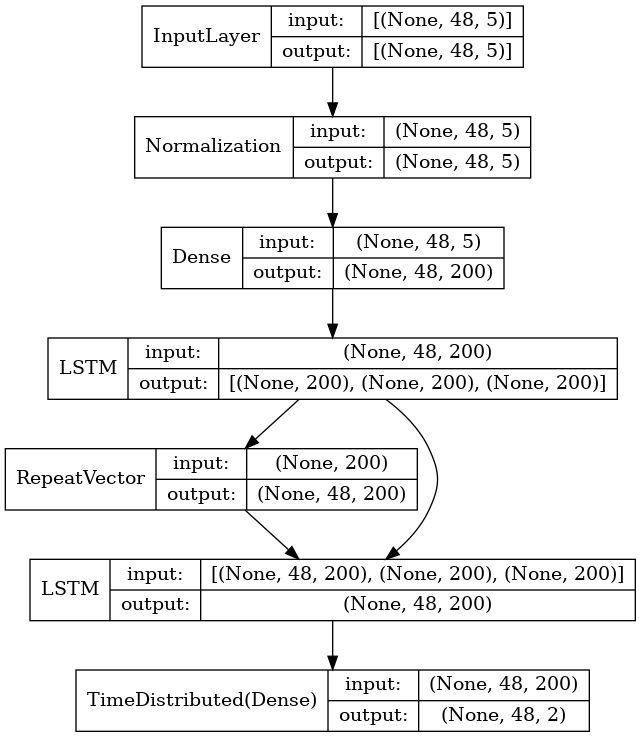

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
# Hyperparameters and callbacks

BATCH  = 1
EPOCHS = 50
LRATE = .0005
FACTOR = .9
PATIENCE = 3

log_dir = os.path.join('../','logs')
model_path = os.path.join('../', 'models', "lstm_weights.hdf5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', 
    #     mode='min', 
    #     factor=FACTOR,
    #     patience=PATIENCE, 
    #     min_lr=1e-4, 
    #     verbose=0),
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss",
    #     mode='min', 
    #     patience=10*BATCH, 
    #     verbose=1)
]

In [ ]:
# try:
#     model.load_weights(model_path)
# except Exception:
#     pass

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LRATE), 
    loss=tf.keras.losses.Huber(), # Less sensitive to outliers # needs a d= set
    #loss=tf.keras.losses.MeanAbsoluteError(), # Less sensitive to outliers 
    #loss=tf.keras.losses.MeanSquaredError(),  # More sensitive to outliers 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=False,
    validation_data=(x_val, y_val), 
    callbacks=callbacks
)

NameError: name 'model' is not defined

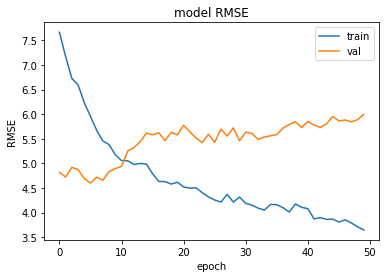

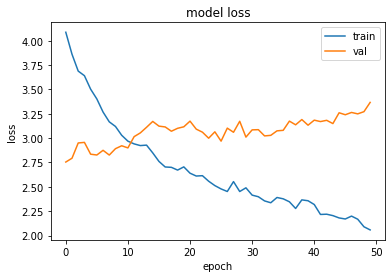

In [ ]:
def plot_history(history, metric):
    # This function will plot the model fit process
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [ ]:
# Evaluate and make predictions
model.load_weights(model_path)
scores = model.evaluate(x_val, y_val, verbose=1, batch_size=BATCH, callbacks=callbacks)
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH, callbacks=callbacks)
y_preds = model.predict(x_test, verbose=1, batch_size=BATCH, callbacks=callbacks)


11/11 [==============================] - 1s 2ms/step


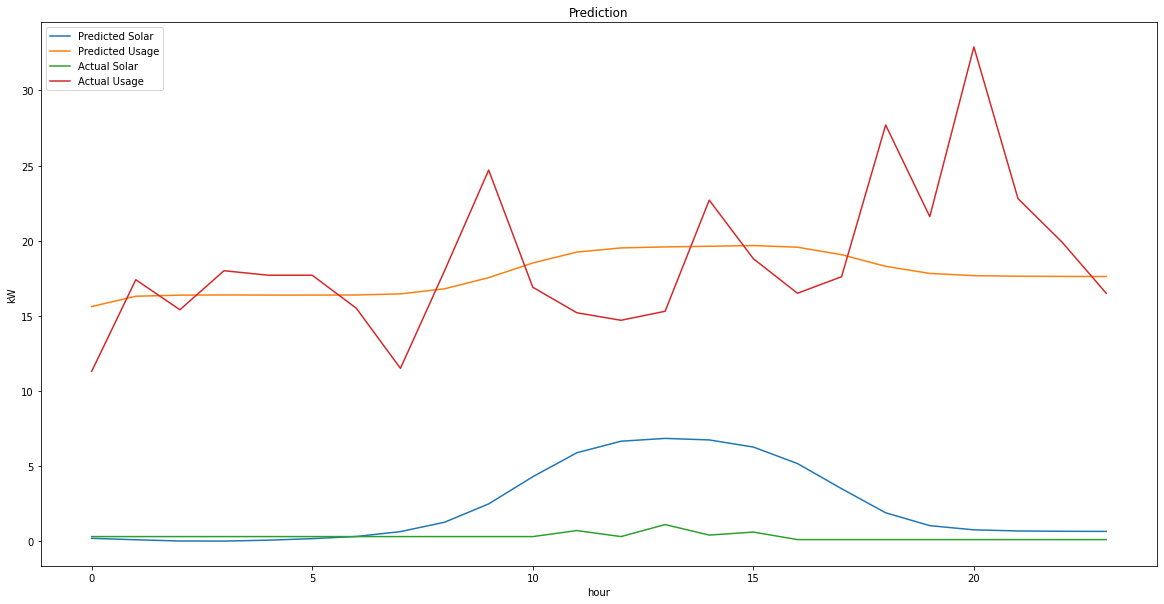

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Prediction')
x = np.random.default_rng().integers(0, y_preds.shape[0])
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage'], loc='upper left')

plt.show()

In [ ]:
task.close()

NameError: name 'task' is not defined